In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import util as u
import pipeline as p
import assess_clf_models as acm
%load_ext autoreload
%autoreload 2

from joblib import dump, load

import itertools

from sklearn.metrics import make_scorer, f1_score, confusion_matrix, precision_score, accuracy_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve, recall_score

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

### Load Data

In [2]:
y_test = u.open_pkl('Data/y_test_10yrs_02.pkl')
y_pred = u.open_pkl('Data/Models/y_pred_cb_10yrs_02.pkl')
y_proba = u.open_pkl('Data/Models/y_proba_cb_10yrs_02.pkl')

Feature Importances & feature names

In [3]:
fis = u.open_pkl('Data/Models/cat_boost_opt_03_fis.pkl')
fns = u.open_pkl('Data/Models/cat_boost_feature_names.pkl')

## Basic Model Eval

[[141937     62]
 [   329    285]]


/Users/kendra/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2362: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


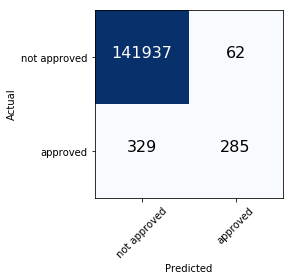

In [4]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
fmt = '0'
thresh = conf_mat.max() / 2.
classes = ['not approved', 'approved']

plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')

for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
    plt.text(j, i, format(conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 size='16',
                 color="white" if conf_mat[i, j] > thresh else "black")

In [5]:
precs = precision_score(y_test,y_pred, average=None)
recalls = recall_score(y_test, y_pred, average=None)
f1s = f1_score(y_test, y_pred, average=None)
aucs = roc_auc_score(y_test,y_proba)
accs = accuracy_score(y_test, y_pred)

twos = [precs, recalls, f1s]
data1 = [[s[j]] for j in range(2) for s in twos]
data1_new = np.mean(data1, axis=1).reshape(1,6)
df1 = pd.DataFrame(data1_new,
         columns=['Precision-0', 'Recall-0 (Specificty)','F1score-0','Precision-1',
         'Recall-1 (Sensitivity)','F1score-1']).mean()
data2 = conf_mat.flatten().reshape(-1,4)
df2 = pd.DataFrame(data2, columns=['TN','FP','FN','TP']).mean()
data3 = np.array([aucs, accs]).reshape(-1, 2)
df3 = pd.DataFrame(data3, columns=['AUC','Accuracy']).mean()

df = df1.append(df2.append(df3))
print(df)

Precision-0                    0.997687
Recall-0 (Specificty)          0.999563
F1score-0                      0.998625
Precision-1                    0.821326
Recall-1 (Sensitivity)         0.464169
F1score-1                      0.593132
TN                        141937.000000
FP                            62.000000
FN                           329.000000
TP                           285.000000
AUC                            0.984186
Accuracy                       0.997258
dtype: float64


In [61]:
df.to_csv('Data/cat_boost_opt_02_fit_10yrs_opt.csv')

## Cost-Benefit Analysis

In [18]:
def cost_function(threshold):
    y_pred = np.array(y_proba > threshold)
    fpos = y_pred * (1 - y_test) 
    fneg = (1 - y_pred) * y_test
    
    cost_fp = fpos * fp_cost
    cost_fn = fneg * tp_rev
    
    return np.sum(cost_fp + cost_fn)

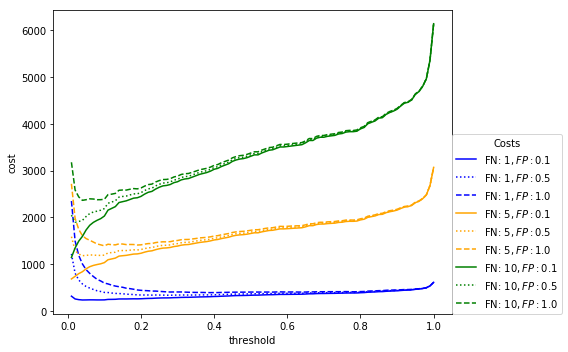

In [66]:
thr_rng = np.linspace(0.01,1,100)
plt.figure(figsize=(8,5))
colors = ['blue', 'orange', 'green']
styles = ['-',':','--']
revs = [1,5,10]
costs = [0.1, 0.5, 1]

for i in range(3):
    tp_rev = revs[i]
    for j in range(3):
        fp_cost = costs[j]
        plt.plot(thr_rng, np.vectorize(cost_function)(thr_rng), label=f'FN: ${tp_rev}, FP: ${fp_cost:.1f}', 
                 color=colors[i], linestyle=styles[j])

plt.legend(title='Costs', loc=(1, 0))
plt.xlabel('threshold')
plt.ylabel('cost');
# plt.xscale('log');

There seem to be two paradigms: 
- "non-blockbuster" (<= \$3 bn revenue) where cost is high initially, then flattens out. Here, safety concerns could dictacte your choice of threshold, with higher confidence/threshold meaning greater safety/lower risk.
- "blockbuster" (\$10 bn revenue) where cost is minimized at low threshold (in fact 0 if development costs are low) and then climbs, as the "cost" of missing out is high

Scenario for presentation:

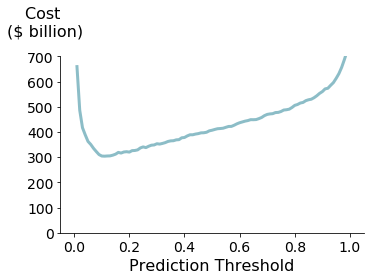

In [46]:
thr_rng = np.linspace(0.01,1,100)
tp_rev = 1.2
fp_cost = 0.2

fig = plt.figure(figsize=(5.3,4))
ax = fig.add_subplot(111)

plt.plot(thr_rng, np.vectorize(cost_function)(thr_rng), lw=3, alpha=0.8, color='#70ADBA')

plt.xlim([-0.05, 1.05])
ax.set_ylabel('Cost \n($ billion)', rotation=0, fontsize=16)
ax.yaxis.set_label_coords(-0.05,1.1)
ymin, ymax = ax.get_ylim()
plt.ylim(0, 700)

plt.xlabel('Prediction Threshold', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.legend(loc=(0.80, 0.45), fontsize=16, frameon=False)
plt.savefig('Figures/Cost_Benefit_Analysis.png', dpi=300, transparent=True)

In [6]:
thr_opt = 0.15

## Precision-Recall Curves

In [7]:
prec, rec, thr = precision_recall_curve(y_test, y_proba)
thr_adj = np.append(thr, 1)

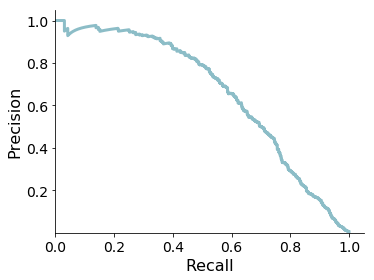

In [12]:
fig = plt.figure(figsize=(5.3,4))
ax = fig.add_subplot(111)

# plt.plot(rec, prec, label="", color='#56939E', lw=3, alpha=.8)
plt.plot(rec, prec, label="", color='#70ADBA', lw=3, alpha=.8)


plt.xlim([-0.0, 1.05])
plt.ylim([-0.0, 1.05])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0],labels=["0.2", "0.4","0.6","0.8","1.0"],fontsize=14)

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
prec_label = "Precision:"
recall_label = "Recall"

plt.savefig('Figures/PR_curve_01.png', dpi=300, transparent=False)

In [13]:
opt_idx = np.argwhere(thr_adj > thr_opt)[0]
prec_opt = prec[opt_idx]
rec_opt = rec[opt_idx]

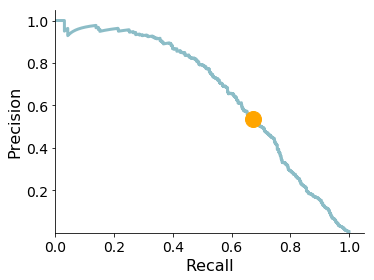

In [14]:
fig = plt.figure(figsize=(5.3,4))

ax = fig.add_subplot(111)

plt.plot(rec, prec, label="", color='#70ADBA', lw=3, alpha=.8)

plt.xlim([-0.0, 1.05])
plt.ylim([-0.0, 1.05])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0],labels=["0.2", "0.4","0.6","0.8","1.0"],fontsize=14)

plt.plot(rec_opt, prec_opt, color='orange', marker='o', markersize=16)

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
prec_label = "Precision:"
recall_label = "Recall"

plt.savefig('Figures/PR_curve_01_with dot.png', dpi=300, transparent=False)

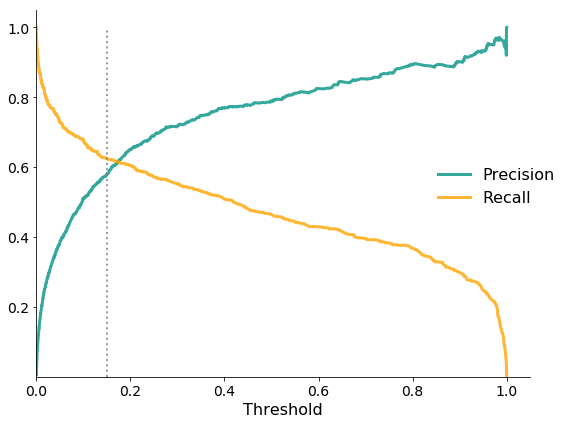

In [33]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

plt.plot(thr_adj, prec, label="Precision", color='xkcd:teal', lw=3, alpha=.8)
plt.plot(thr_adj, rec, label="Recall", color='orange', lw=3, alpha=.8)

plt.xlim([-0.0, 1.05])
plt.ylim([-0.0, 1.05])
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0],labels=["0.2", "0.4","0.6","0.8","1.0"],fontsize=14)

plt.plot([thr_opt, thr_opt], [0, 1], linestyle=':', lw=2, color='grey',alpha=.8)
# plt.text(0.3, 0.78, f'Precision: {precs[1]:.2f}', fontsize=16, color='xkcd:teal', multialignment='center')

plt.xlabel('Threshold', fontsize=16)
# plt.ylabel('Value', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(loc=(0.80, 0.45), fontsize=16, frameon=False)
# plt.title('Precision & Recall vs. Threshold', fontsize=18)
plt.savefig('Figures/PRT_curve_01.png', dpi=300, transparent=False)

### Basic Eval at optimal threshold

[[141638    361]
 [   200    414]]


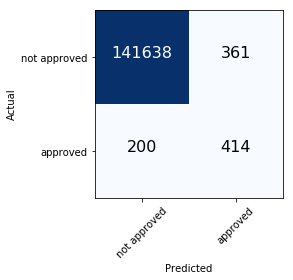

In [9]:
y_pred = [1 if x > thr_opt else 0 for x in y_proba]
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
fmt = '0'
thresh = conf_mat.max() / 2.
classes = ['not approved', 'approved']

plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')

for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
    plt.text(j, i, format(conf_mat[i, j], fmt),
                 horizontalalignment="center",
                 size='16',
                 color="white" if conf_mat[i, j] > thresh else "black")

In [10]:
precs = precision_score(y_test,y_pred, average=None)
recalls = recall_score(y_test, y_pred, average=None)
f1s = f1_score(y_test, y_pred, average=None)
aucs = roc_auc_score(y_test,y_proba)
accs = accuracy_score(y_test, y_pred)

twos = [precs, recalls, f1s]
data1 = [[s[j]] for j in range(2) for s in twos]
data1_new = np.mean(data1, axis=1).reshape(1,6)
df1 = pd.DataFrame(data1_new,
         columns=['Precision-0', 'Recall-0 (Specificty)','F1score-0','Precision-1',
         'Recall-1 (Sensitivity)','F1score-1']).mean()
data2 = conf_mat.flatten().reshape(-1,4)
df2 = pd.DataFrame(data2, columns=['TN','FP','FN','TP']).mean()
data3 = np.array([aucs, accs]).reshape(-1, 2)
df3 = pd.DataFrame(data3, columns=['AUC','Accuracy']).mean()

df = df1.append(df2.append(df3))
print(df)

Precision-0                    0.998590
Recall-0 (Specificty)          0.997458
F1score-0                      0.998024
Precision-1                    0.534194
Recall-1 (Sensitivity)         0.674267
F1score-1                      0.596112
TN                        141638.000000
FP                           361.000000
FN                           200.000000
TP                           414.000000
AUC                            0.984186
Accuracy                       0.996066
dtype: float64


## Bar Chart

In [10]:
mod_color = 'xkcd:goldenrod'
sq_color = 'xkcd:grey blue'

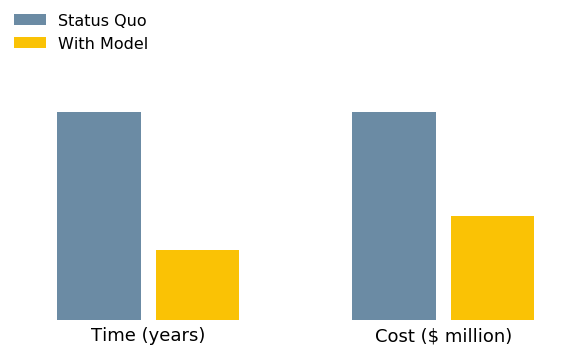

In [15]:
n = 2
xs = np.arange(n*3)
w = 0.85

plt.figure(figsize=(8,5))
plt.bar(xs[::3], [1.5, 1.5], width=w, label='Status Quo', color=sq_color)
plt.bar(xs[1::3], [0.5, 0.75], width=w, label='With Model', color=mod_color)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(left=False, bottom=False, labelleft=False) 

plt.xticks(xs[1::3]-0.5, ["Time (years)", "Cost ($ million)"], fontsize=18)#[f'{x}' for x in xs])
plt.yticks(fontsize=16)
# ax.set_ylabel('$ Billions', rotation=0, fontsize=18)
# ax.yaxis.set_label_coords(-0.05,1.0)

plt.legend(fontsize=16, frameon=False, loc=(-0.05, 1.2));
plt.savefig('Figures/Cost_Profit.png', dpi=300, transparent=True)

## Feature Importances

Text(0.5, 1.0, 'Feature Importances')

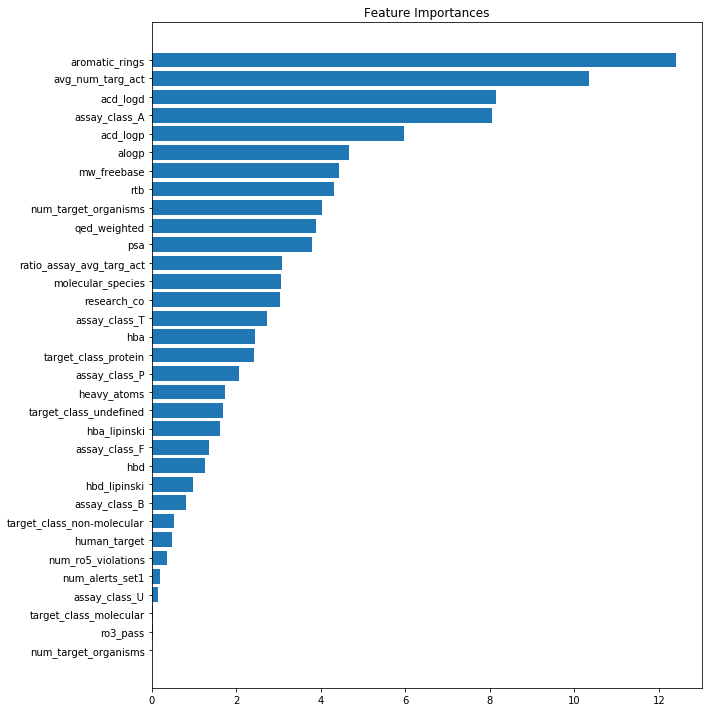

In [5]:
fi_list = list(zip(fns, fis))
fi_list.sort(reverse=False, key=lambda x: x[1])

labels = [x[0] for x in fi_list]
imp = [x[1] for x in fi_list]

plt.figure(figsize=(10,10))
plt.barh(y=range(len(fi_list)), width=list(zip(*fi_list))[1], tick_label = list(zip(*fi_list))[0])
plt.title("Feature Importances")
# plt.barh(y=range(len(fis[0])), width = fis_sorted)